In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
!pip install graphviz
!pip install --upgrade keras tensorflow
!apt-get install git






CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2243%2F9243%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T142237Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dd26b23decfef11ad2f90db0aa422e175df3c528e9500a1ab90e307eb4f3b85f147a73ae4dba398a1bcc5b87ff7743eefaacb958908a9d76b0330eadb7acb718357044b28337a7798d06475528b70f980f7cd0fa03e5222aad9236860be1f08ed1d59fb159c8081ce51f62691c857268f68418e24161e7af4b67b941704f430d5c43675b130770beadd9b74f0a7b378a35ecd8c2592285ea9f1f592d97d3bc6a9e8257557036e5d1bfecc9499f4a4611dcfff2564286647c7129279baa2e0e4d6f08c22b17e6926f5cf386b91928d6571cb291e39a339cb586a2ee1de984c99273fa8ad163b3ff341931eeba7e085954c2ba59f3576e0d1aeb8c0162126d21d26'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
[==================================================] 72114846 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


 <h1><center><font size="6">CNN with Tensorflow|Keras for Fashion MNIST</font></center></h1>


<center><img src="https://research.zalando.com/project/fashion_mnist/fashion_mnist/img/fashion-mnist-sprite.png" width="600"></img></center>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Data exploration</a>
    - <a href='#41'>Class distribution</a>
    - <a href='#42'>Images samples</a>
- <a href='#5'>Model</a>  
    - <a href='#51'>Prepare the model</a>  
    - <a href='#52'>Train the model</a>  
    - <a href='#53'>Test prediction accuracy</a>   
    - <a href='#54'>Validation accuracy and loss</a>   
    - <a href='#55'>Add Dropout layers to the model</a>  
    - <a href='#56'>Re-train the model</a>   
    - <a href='#57'>Check validation accuracy and loss with the new model</a>    
    - <a href='#58'>Prediction accuracy with the new model </a>   
- <a href='#6'>Visualize the classified images</a>  
    - <a href='#61'>Correctly classified images</a>   
    - <a href='#62'>Incorrectly classified images</a>   
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>

# <a id="1">Introduction</a>  


## Dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.


## Content

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.   

Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.   

The training and test data sets have 785 columns.   

The first column consists of the class labels (see above), and represents the article of clothing.

The rest of 784 columns (1-785) contain the pixel-values of the associated image.

# <a id="2">Load packages</a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
import tensorflow as tf
!pip install --upgrade tensorflow
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Parameters

In [ ]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 2018
#Model
NO_EPOCHS = 50
BATCH_SIZE = 128

IS_LOCAL = False

import os

if(IS_LOCAL):
    PATH="../input/fashionmnist/"
else:
    PATH="../input/"
print(os.listdir(PATH))

['train-labels-idx1-ubyte', 't10k-images-idx3-ubyte', 'fashion-mnist_train.csv', 't10k-labels-idx1-ubyte', 'train-images-idx3-ubyte', 'fashion-mnist_test.csv']


# <a id="3">Read the data</a>

There are 10 different classes of images, as following:

* **0**: **T-shirt/top**;   
* **1**: **Trouser**;   
* **2**: **Pullover**;   
* **3**: **Dress**;
* **4**: **Coat**;
* **5**: **Sandal**;
* **6**: **Shirt**;
* **7**: **Sneaker**;
* **8**: **Bag**;
* **9**: **Ankle boot**.

Image dimmensions are **28**x**28**.   

The train set and test set are given in two separate datasets.


In [ ]:
train_file = PATH+"fashion-mnist_train.csv"
test_file  = PATH+"fashion-mnist_test.csv"

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# <a id="4">Data exploration</a>

![](http://)The dimmension of the original  train,  test set are as following:

In [ ]:
print("Fashion MNIST train -  rows:",train_data.shape[0]," columns:", train_data.shape[1])
print("Fashion MNIST test -  rows:",test_data.shape[0]," columns:", test_data.shape[1])

Fashion MNIST train -  rows: 60000  columns: 785
Fashion MNIST test -  rows: 10000  columns: 785


## <a id="41">Class distribution</a>

Let's see how many number of images are in each class. We start with the train set.

### Train set images class distribution

In [ ]:
# Create a dictionary for each type of label
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(train_data)

Pullover            :   6000 or 10.0%
Ankle Boot          :   6000 or 10.0%
Shirt               :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Bag                 :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Trouser             :   6000 or 10.0%


The classes are equaly distributed in the train set (10% each). Let's check the same for the test set.    
Let's also plot the class distribution.



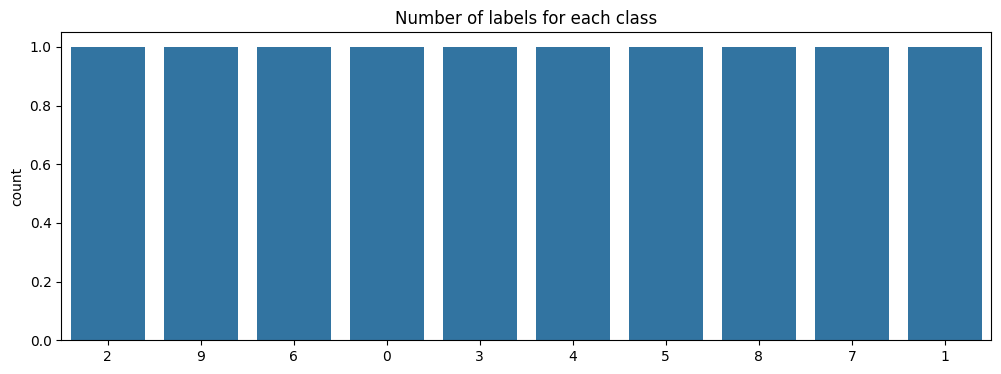

In [ ]:
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data.label, order = data["label"].value_counts().index)
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["label"].value_counts().index):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
    plt.show()

plot_label_per_class(train_data)

### Test set images class distribution

In [ ]:
get_classes_distribution(test_data)

T-shirt/top         :   1000 or 10.0%
Trouser             :   1000 or 10.0%
Pullover            :   1000 or 10.0%
Dress               :   1000 or 10.0%
Bag                 :   1000 or 10.0%
Shirt               :   1000 or 10.0%
Sandal              :   1000 or 10.0%
Coat                :   1000 or 10.0%
Sneaker             :   1000 or 10.0%
Ankle Boot          :   1000 or 10.0%


Also in the test set the 10 classes are equaly distributed (10% each).  

Lets' also plot the class distribution.

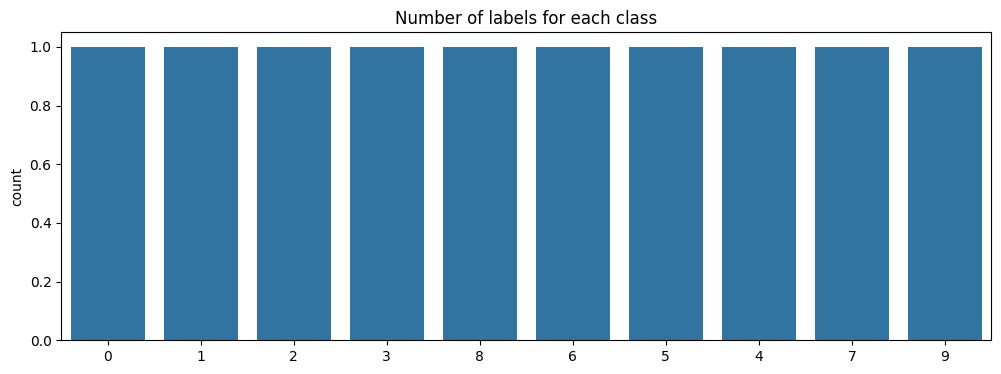

In [ ]:
plot_label_per_class(test_data)

## <a id="42">Sample images</a>

### Train set images

Let's plot some samples for the images.   
We add labels to the train set images, with the corresponding fashion item category.  

In [ ]:
def sample_images_data(data):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in labels.keys():
        # Get four samples for each category
        samples = data[data["label"] == k].head(4)
        # Append the samples to the samples list
        for j, s in enumerate(samples.values):
            # First column contain labels, hence index should start from 1
            img = np.array(samples.iloc[j, 1:]).reshape(IMG_ROWS,IMG_COLS)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

train_sample_images, train_sample_labels = sample_images_data(train_data)

Total number of sample images to plot:  40


Let's now plot the images.   
The labels are shown above each image.

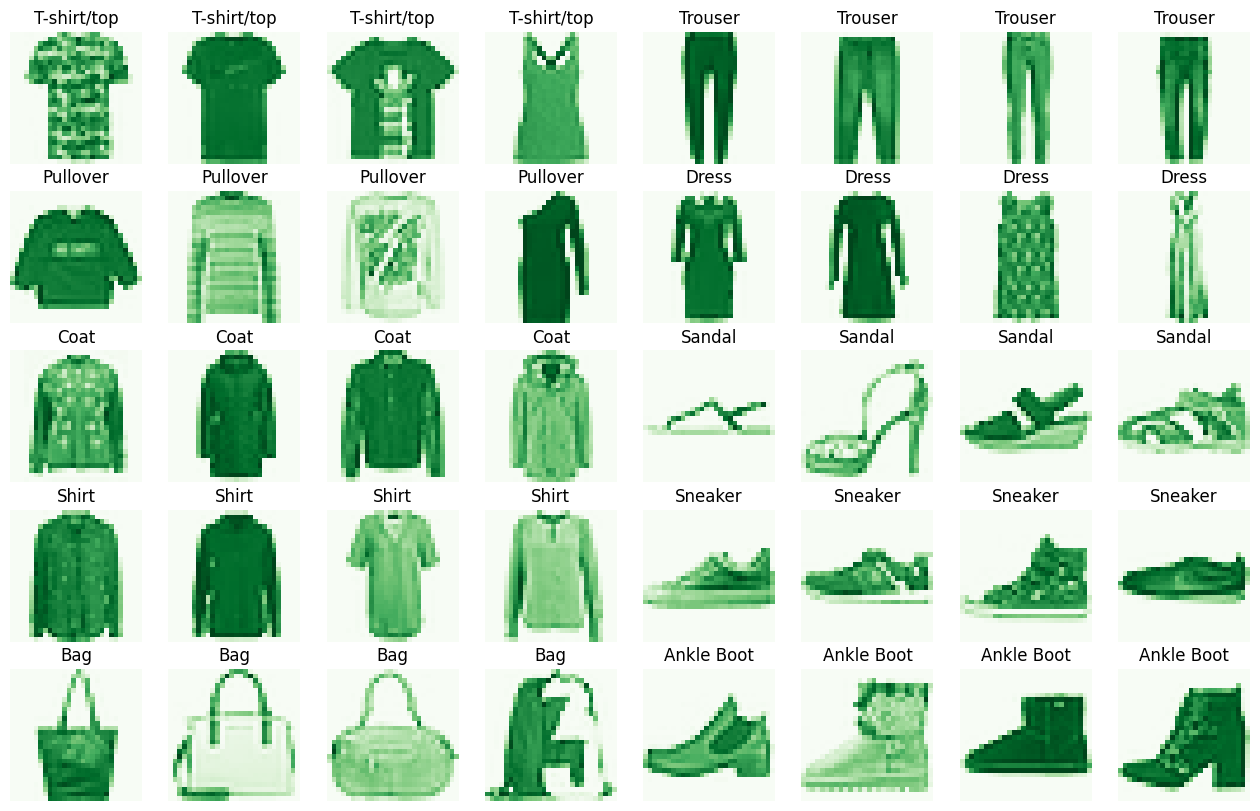

In [ ]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,8, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()

plot_sample_images(train_sample_images,train_sample_labels, "Greens")

### Test set images

Let's plot now a selection of the test set images.  
Labels are as well added (they are known).  

Total number of sample images to plot:  40


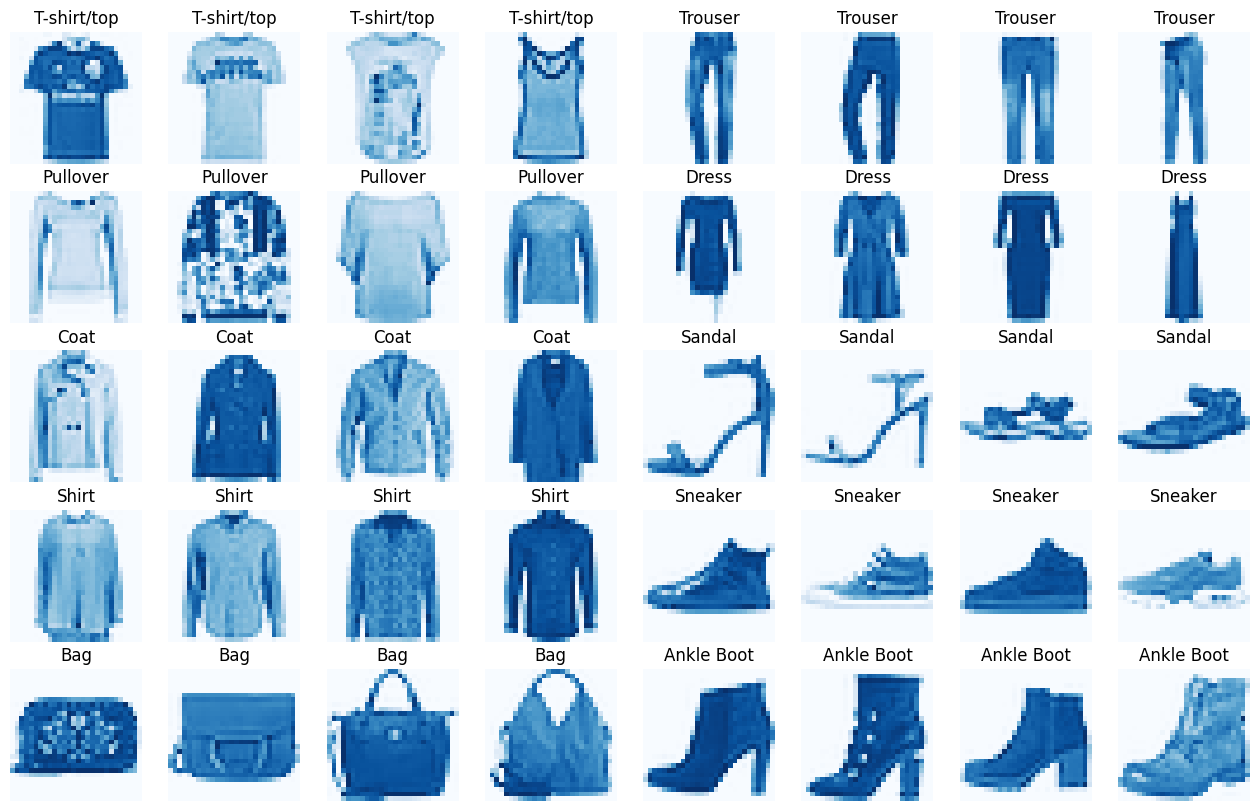

In [ ]:
test_sample_images, test_sample_labels = sample_images_data(test_data)
plot_sample_images(test_sample_images,test_sample_labels)

# <a id="5">Model</a>

We start with preparing the model.

## <a id="51">Prepare the model</a>

## Data preprocessing

First we will do a data preprocessing to prepare for the model.

We reshape the columns  from (784) to (28,28,1). We also save label (target) feature as a separate vector.

In [ ]:
# data preprocessing
def data_preprocessing(raw):
    out_y = to_categorical(raw.label, NUM_CLASSES)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

We process both the train_data and the test_data

In [ ]:
# prepare the data
X, y = data_preprocessing(train_data)
X_test, y_test = data_preprocessing(test_data)

## Split train in train and validation set

We further split the train set in train and validation set. The validation set will be 20% from the original train set, therefore the split will be train/validation of 0.8/0.2.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

The dimmension of the processed train, validation and test set are as following:

In [ ]:
print("Fashion MNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("Fashion MNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

Fashion MNIST train -  rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


Let's check the class inbalance for the rsulted training set.

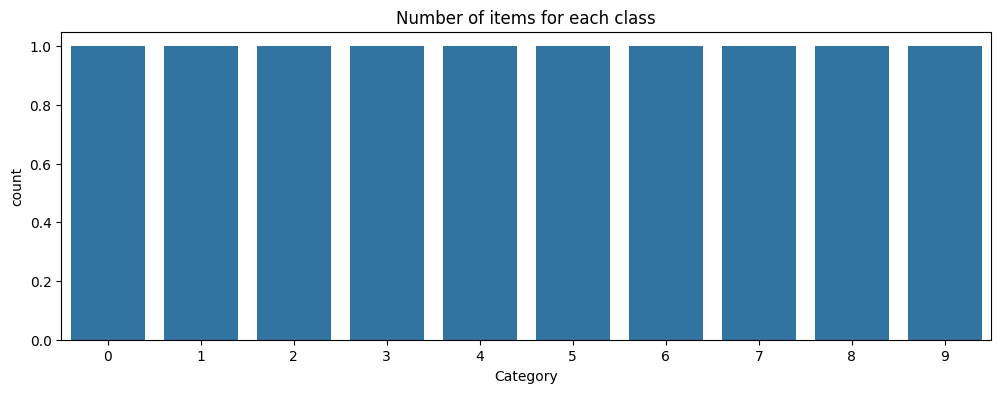

Dress               :   4891 or 10.189583333333333%
Sandal              :   4855 or 10.114583333333334%
Pullover            :   4836 or 10.075000000000001%
Ankle Boot          :   4827 or 10.05625%
Sneaker             :   4798 or 9.995833333333334%
Coat                :   4796 or 9.991666666666667%
Shirt               :   4779 or 9.95625%
Bag                 :   4757 or 9.910416666666666%
Trouser             :   4745 or 9.885416666666668%
T-shirt/top         :   4716 or 9.825000000000001%


In [ ]:
def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(ydf[0], order = np.arange(0,10))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")

    for p, label in zip(g.patches, np.arange(0,10)):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))

    plt.show()

def get_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    # Get the count for each label
    label_counts = ydf[0].value_counts()

    # Get total number of samples
    total_samples = len(yd)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

plot_count_per_class(np.argmax(y_train,axis=1))
get_count_per_class(np.argmax(y_train,axis=1))

And, as well, for the validation set.

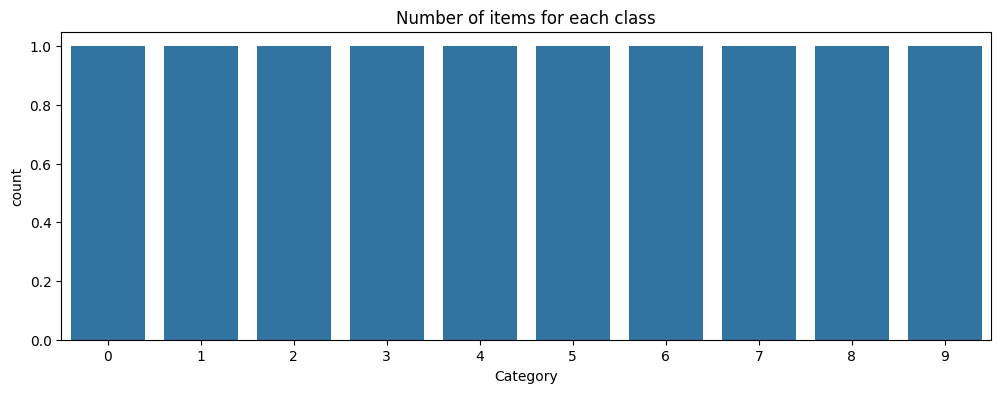

T-shirt/top         :   1284 or 10.7%
Trouser             :   1255 or 10.458333333333334%
Bag                 :   1243 or 10.358333333333333%
Shirt               :   1221 or 10.174999999999999%
Coat                :   1204 or 10.033333333333333%
Sneaker             :   1202 or 10.016666666666667%
Ankle Boot          :   1173 or 9.775%
Pullover            :   1164 or 9.700000000000001%
Sandal              :   1145 or 9.541666666666666%
Dress               :   1109 or 9.241666666666665%


In [ ]:
plot_count_per_class(np.argmax(y_val,axis=1))
get_count_per_class(np.argmax(y_val,axis=1))

Both the train and validation set are unbalanced with respect of distribution of classes.

## <a id="52">Train the model</a>

### Build the model   



We will use a **Sequential** model.
* The **Sequential** model is a linear stack of layers. It can be first initialized and then we add layers using **add** method or we can add all layers at init stage. The layers added are as follows:

* **Conv2D** is a 2D Convolutional layer (i.e. spatial convolution over images). The parameters used are:
 * filters - the number of filters (Kernels) used with this layer; here filters = 32;
 * kernel_size - the dimmension of the Kernel: (3 x 3);
 * activation - is the activation function used, in this case `relu`;
 * kernel_initializer - the function used for initializing the kernel;
 * input_shape - is the shape of the image presented to the CNN: in our case is 28 x 28
 The input and output of the **Conv2D** is a 4D tensor.

* **MaxPooling2D** is a Max pooling operation for spatial data. Parameters used here are:
 * *pool_size*, in this case (2,2), representing the factors by which to downscale in both directions;

 * **Conv2D** with the following parameters:
 * filters: 64;
 * kernel_size : (3 x 3);
 * activation : `relu`;

* **MaxPooling2D** with parameter:
 * *pool_size* : (2,2);

* **Conv2D** with the following parameters:
 * filters: 128;
 * kernel_size : (3 x 3);
 * activation : `relu`;

* **Flatten**. This layer Flattens the input. Does not affect the batch size. It is used without parameters;

* **Dense**. This layer is a regular fully-connected NN layer. It is used without parameters;
 * units - this is a positive integer, with the meaning: dimensionality of the output space; in this case is: 128;
 * activation - activation function : `relu`;

* **Dense**. This is the final layer (fully connected). It is used with the parameters:
 * units: the number of classes (in our case 10);
 * activation : `softmax`; for this final layer it is used `softmax` activation (standard for multiclass classification)


Then we compile the model, specifying as well the following parameters:
* *loss*;
* *optimizer*;
* *metrics*.


In [ ]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

### Inspect the model

Let's check the model we initialized.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

Let's also plot the model

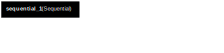

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

AttributeError: module 'tensorflow.python.distribute.input_lib' has no attribute 'DistributedDatasetInterface'

## <a id="53">Test prediction accuracy</a>

We calculate the test loss and accuracy.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test accuracy is  around  0.91.

We evaluated the model accuracy based on the predicted values for the test set.  Let's check the validation value during training.



## <a id="53">Validation accuracy and loss</a>

Let's plot the train and validation accuracy and loss, from the train history.

In [ ]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))

    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")

    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])


    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model)

The validation accuracy does not improve after few epochs and the validation loss is increasing after few epochs. This confirms our assumption that the model is overfitted. We will try to improve the model by adding Dropout layers.

## <a id="55">Add Dropout layers to the model</a>

We add several Dropout layers to the model, to help avoiding overfitting.    
Dropout is helping avoid overfitting in several ways, as explained in <a href='#8'>[6]</a> and <a href='#8'>[7]</a>.  


In [ ]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

## <a id="56">Re-train the model</a>

Let's inspect first the model.

In [ ]:
model.summary()

Let's also plot the model.

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

And now let's run the new model.

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

## <a id="57">Prediction accuracy with the new model</a>

Let's re-evaluate the prediction accuracy with the new model.

In [ ]:
plot_accuracy_and_loss(train_model)

After adding the Dropout layers, the validation accuracy and validation loss are much better. Let's check now the prediction for the test set.


## <a id="58">Prediction accuracy with the new model</a>

Let's re-evaluate the test prediction accuracy with the new model.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Also the test accuracy improved. The test accuracy is now approximately 0.93.

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)
#get the indices to be plotted
y_true = test_data.iloc[:, 0]

In [ ]:
p = predicted_classes[:10000]
y = y_true[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

In [ ]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

In [ ]:
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))


The best accuracy is obtained for Class 1, Class 5, Class 8, Class 9  and Class 7. Worst accuracy is for Class 6.   

The recall is highest for Class 8, Class 5 and smallest for Class 6 and Class 4.    

f1-score is highest for Class 1, Class 5 and Class 8 and smallest for Class 6 followed by Class 4 and Class 2.  

Let's also inspect some of the images. We created two subsets of the predicted images set, correctly and incorrectly classified.

# <a id="6">Visualize classified images</a>

## <a id="61">Correctly classified images</a>


We visualize few images correctly classified.

In [ ]:
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(15,15))

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(X_test[indx].reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[y_true[indx]],labels[predicted_classes[indx]]))
    plt.show()

plot_images(correct, "Greens")

## <a id="62">Incorrectly classified images</a>

Let's see also few images incorrectly classified.

In [ ]:
plot_images(incorrect, "Reds")

# <a id="7">Conclusions</a>

With a complex sequential model with multiple convolution layers and 50 epochs for the training, we obtained an accuracy ~0.91 for test prediction.
After investigating the validation accuracy and loss, we understood that the model is overfitting.   
We retrained the model with Dropout layers to the model to reduce overfitting.  
We confirmed the model improvement and with the same number of epochs for the training we obtained with the new model an accuracy of ~0.93 for test prediction. Only few classes are not correctly classified all the time, especially Class 6 (Shirt) and Class 2 (Pullover).

# <a id="8">References</a>

[1] Fashion MNIST, An MNIST-like dataset of 70,000 28x28 labeled fashion images, https://www.kaggle.com/zalando-research/fashionmnist  
[2] DanB, CollinMoris, Deep Learning From Scratch, https://www.kaggle.com/dansbecker/deep-learning-from-scratch  
[3] DanB, Dropout and Strides for Larger Models, https://www.kaggle.com/dansbecker/dropout-and-strides-for-larger-models  
[4] BGO, CNN with Keras, https://www.kaggle.com/bugraokcu/cnn-with-keras    
[5] NAIN, EagerFMINST, https://www.kaggle.com/aakashnain/eagerfmnist  
[6] Why Dropounts prevent overfitting in Deep Neural Networks, https://medium.com/@vivek.yadav/why-dropouts-prevent-overfitting-in-deep-neural-networks-937e2543a701  
[7] Dropout: A Simple Way to Prevent Neural Networks from Overfitting, https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf  